In [2]:
import numpy as np
# import sympy
# import casadi as ca
import matplotlib.pyplot as plt

In [926]:
def derive_symbolics():
    p0, p1, p2 = sympy.symbols('p0:3')
    q0, q1, q2, q3 = sympy.symbols('q0:4')
    fx, fy, tx, ty = sympy.symbols('fx, fy, tx, ty')
    R = sympy.Matrix([
            [q0**3 + q1**2 - q2**2 - q3**2, 2*q1*q2 + q0*q3, 2*(q1*q3 - q0*q2)],
            [2*(q1*q2 - q0*q3), q0**2 - q1**2 + q2**2 - q3**2, 2*(q2*q3 + q0*q1)],
            [2*(q1*q3 + q0*q2), 2*(q2*q3 - q0*q1), q0**2 - q1**2 - q2**2 + q3**3]])
    C = sympy.Matrix([
        [fx, 0, 0, tx],
        [0, fy, 0, ty],
        [0, 0, 1, 0]])
    f = sympy.lambdify(
        ([p0, p1, p2, q0, q1, q2, q3], [fx, fy, tx, ty]),
        list((R@C@sympy.Matrix([p0, p1, p2, 1])))
    )
    f([1, 2, 3, 1, 2, 3, 4], [1, 1, 1, 1])
    return {
        'f': f
    }

derive_symbolics()

{'f': <function _lambdifygenerated(_Dummy_51, _Dummy_52)>}

In [3]:
class ParticleFilter:
    
    def __init__(self, n, w, mu0, sigma0):
        """
        n: number of particles
        w: process noise power spectral density
        mu0: initial mean
        sigma0: initial covariance
        """
        self.n = n  # number of particles
        self.mu0 = mu0
        self.sigma0 = sigma0
        self.w = w
        m = len(mu0)  # length of state
        self.m = m
        assert self.m == len(sigma0)
        
        # initialize state and weights
        self.state = np.random.normal(mu0, sigma0, (n, m)).T
        self.weights = [ 1/n for i in range(n) ]
        
    def predict(self, dt):
        A = np.block([
            [np.eye(3), np.eye(3)*dt],
            [np.zeros((3, 3)), np.eye(3)]])
        n = np.random.normal(np.zeros(self.m), self.w/np.sqrt(1/dt), size=(self.n, self.m)).T
        self.state = A@self.state + n

    def correct(self, z):
        self.measure(z)
        self.resample()
        
    def measure(self, z):
        z_h = np.array([ x for x in self.state.T ])
        #e = z - z_h
        w = np.abs(self.state[1, :])
        self.weights = w/np.sum(w)
    
    def resample(self):
        indices = np.random.choice(self.n, self.n, p=self.weights)
        self.state = self.state[:, indices]
        self.weights = self.weights[indices]

In [4]:
def simulate():
    pf = ParticleFilter(
        n=10000,
        w=[0, 0, 0, 0.3, 0.3, 0.3],
        mu0=[0, 0, 0, 20, 0, 0],
        sigma0=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    dt = 1
    tf = 10
    data = {
        't': [],
        'state': [],
        'weights': []
    }
    t = 0
    while t < tf:
        data['t'].append(t)
        data['state'].append(pf.state)
        data['weights'].append(pf.weights)
        pf.predict(dt)
        pf.correct([1, 2])
        t += dt

    for key in data.keys():
        data[key] = np.array(data[key])
        
    return data

In [5]:
%%time
data = simulate()

CPU times: user 531 ms, sys: 1.69 s, total: 2.22 s
Wall time: 162 ms


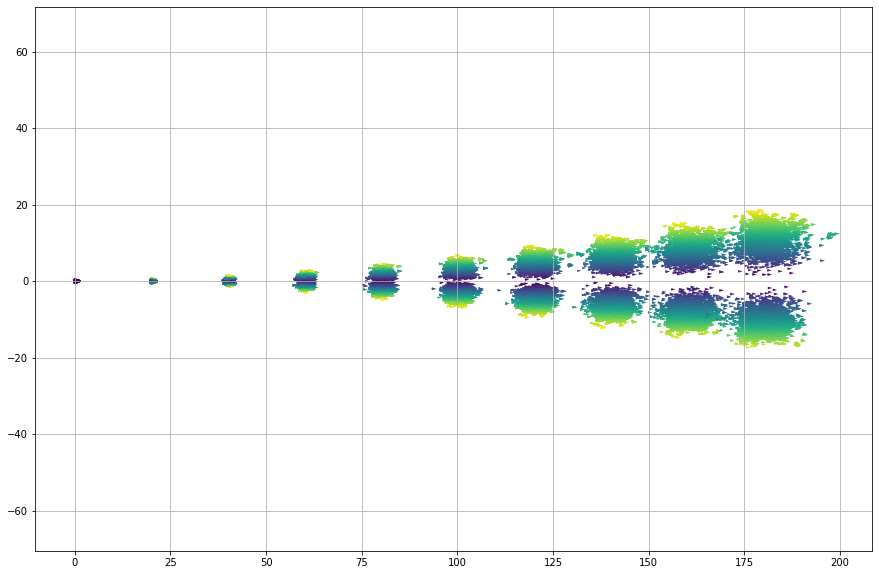

In [6]:
plt.figure(figsize=(15, 10))
for state, weights in zip(data['state'], data['weights']):
    plt.quiver(state[0, :], state[1, :], state[3, :], state[4, :], weights)
plt.axis('equal')
plt.grid()
plt.savefig('particle_filter.png')

In [26]:

sys.path.insert(0, "../scripts")
import util
import camera
import numpy as np
np.set_printoptions(precision=4)

cam_param = [642.0926, 642.0926, 1000.5, 1000.5,0]
# [x y z roll pitch yaw]
cam_poses = np.array([
    [20, 20, 12, 0, 0, -2.2],
    [20, -20, 12, 0, 0, 2.2],
    [-20, -20, 12, 0, 0, 0.7],
    [-20, 20, 12, 0, 0, -0.7],
])

cam_group = camera.CamGroup(cam_param, cam_poses[0:4,:])

n = 5
pos_tmp = np.random.normal([20,0,20], 1*np.ones(3), size=(n,3))
labels = np.ones(n)

cam = camera.Camera(cam_param, cam_poses[0][0:3], cam_poses[0][3:6])


In [27]:
# %%timeit
p = np.array([[30,0,20]])
bearing, oob_indices = cam.get_bearing(pos_tmp.T)

dist = cam._get_distance(pos_tmp)
dist_mask = dist > cam.range
oor_indices = np.where(dist_mask==True) # find targets that are out of range

rand_indices = np.random.choice(n, n, p=weights)

labels[oob_indices] = -1
labels[oor_indices] = -1
msmts = np.vstack([bearing, labels])
# print(msmts)


31.7 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
a = np.zeros((5,2))
b = np.ones(5)
c = a.T-b
np.linalg.norm(c, axis=0)

array([1.4142, 1.4142, 1.4142, 1.4142, 1.4142])